# Exploring Pipelines and Wrapping Up Phase 3

## Why Pipeline?

Pipelines can keep our code neat and clean all the way from gathering & cleaning our data, to creating models & fine-tuning them!

**Advantages**: 
- Reduces complexity
- Convenient 
- Flexible 
- Can help prevent mistakes (like data leakage between train and test set) 

Easily integrate transformers and estimators, plus cross validation!

<img src="images/grid_search_cross_validation.png" alt="cross validation image from sklearn's documentation" width=500>

Why might CV be good in instances when we're doing things like searching for optimal hyperparameters...?

- 


In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix

import category_encoders as ce

In [2]:
# May need to install category_encoders if you'd like to use it:
# !conda install -c conda-forge category_encoders

Data source: https://www.kaggle.com/c/cat-in-the-dat-ii

In [5]:
# Grab, then explore data
df = pd.read_csv('data/cat_in_the_dat2_train.csv', index_col='id')

In [6]:
df.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bin_0   582106 non-null  float64
 1   bin_1   581997 non-null  float64
 2   bin_2   582070 non-null  float64
 3   bin_3   581986 non-null  object 
 4   bin_4   581953 non-null  object 
 5   nom_0   581748 non-null  object 
 6   nom_1   581844 non-null  object 
 7   nom_2   581965 non-null  object 
 8   nom_3   581879 non-null  object 
 9   nom_4   581965 non-null  object 
 10  nom_5   582222 non-null  object 
 11  nom_6   581869 non-null  object 
 12  nom_7   581997 non-null  object 
 13  nom_8   582245 non-null  object 
 14  nom_9   581927 non-null  object 
 15  ord_0   581712 non-null  float64
 16  ord_1   581959 non-null  object 
 17  ord_2   581925 non-null  object 
 18  ord_3   582084 non-null  object 
 19  ord_4   582070 non-null  object 
 20  ord_5   582287 non-null  object 
 21  day     58

In [9]:
# Exploring numeric cols
df.describe()

,bin_0,bin_1,bin_2,ord_0,day,month,target
count,582106.000000,581997.000000,582070.000000,581712.000000,582048.000000,582012.000000,600000.000000
mean,0.092301,0.185532,0.278704,1.948224,4.112767,6.371317,0.187205
std,0.289451,0.388729,0.448362,0.853904,2.034430,3.458959,0.390076
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000,0.000000
50%,0.000000,0.000000,0.000000,2.000000,5.000000,6.000000,0.000000
75%,0.000000,0.000000,1.000000,3.000000,6.000000,8.000000,0.000000
max,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000,1.000000


In [10]:
df['ord_5'].dtype

dtype('O')

In [ ]:
obj_cols = []
for c in df.columns:
    if df[c].dtype == 'object':
        obj_cols.append(c)

In [14]:
obj_cols = [c for c in df.columns if df[c].dtype == 'object']

In [15]:
obj_cols

['bin_3',
 'bin_4',
 'nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_5']

In [13]:
# Exploring object cols
df[[c for c in df.columns if df[c].dtype == 'object']].describe()

,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_1,ord_2,ord_3,ord_4,ord_5
count,581986,581953,581748,581844,581965,581879,581965,582222,581869,581997,582245,581927,581959,581925,582084,582070,582287
unique,2,2,3,6,6,6,4,1220,1519,222,222,2218,5,6,15,26,190
top,F,N,Red,Triangle,Hamster,India,Theremin,fc8fc7e56,ea8c5e181,4ae48e857,7d7c02c57,8f3276a6e,Novice,Freezing,n,N,Fl
freq,366212,312344,323286,164190,164897,164869,308621,977,805,5035,5052,565,160597,142726,70982,39978,10562


In [35]:
70982/600000

0.11830333333333333

In [18]:
# Exploring target distribution
df['target'].value_counts(normalize=True)

0    0.812795
1    0.187205
Name: target, dtype: float64

In [20]:
# Define our X and y
X = df.drop('target', axis = 1)
y = df['target']

# and train test split - to create our val holdout set!
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42)

### Baseline Model

Let's find out how hard our problem is, by throwing things at it and seeing what sticks!

Biggest thing to think about - what types of columns need to be treated differently?

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [23]:
X_train['bin_0'].unique()

array([ 0.,  1., nan])

In [25]:
# Set up how to treat our columns
num_cols = []
cols_to_ohe = []
cols_to_freq = []

for c in X_train.columns:
    # Want to grab numeric columns
    if X_train[c].dtype in ['float64', 'int64']:
        # same as if X_train[c].dtype == 'float64'
        num_cols.append(c)

    # Then grab columns with fewer than 10 unique values
    elif len(X_train[c].unique()) < 10:
        cols_to_ohe.append(c)

    # Then grab columns with more than 10, since we won't OHE those
    else:
        cols_to_freq.append(c)

In [26]:
# Check our work
num_cols

['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day', 'month']

In [27]:
cols_to_ohe

['bin_3',
 'bin_4',
 'nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'ord_1',
 'ord_2']

In [28]:
cols_to_freq

['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_3', 'ord_4', 'ord_5']

In [30]:
# Now, set up the preprocessing steps for each type of col
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

In [31]:
ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohencoder', OneHotEncoder(handle_unknown='ignore'))])

In [32]:
freq_transformer = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('freq_enc', ce.count.CountEncoder(normalize=True, 
                                       handle_unknown=0,
                                       min_group_size=0.001,
                                       min_group_name='Other'))])

In [36]:
df['target'].value_counts()

0    487677
1    112323
Name: target, dtype: int64

In [37]:
df['target'].value_counts(normalize=True)

0    0.812795
1    0.187205
Name: target, dtype: float64

In [38]:
# Put together our preprocessor using a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, cols_to_ohe),
        ('freq', freq_transformer, cols_to_freq)])

In [40]:
# Just out of curiosity, let's see what this looks like 
preprocessor.fit_transform(X_train).shape

(540000, 63)

If you want to get feature names out of a pipeline transformer:

https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html

In [42]:
pd.DataFrame(preprocessor.fit_transform(X_train)).head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.0,0.0,1.0,0.0,0.333333,0.090909,1.0,0.0,0.0,0.0,...,0.0,0.0,0.001174,0.620763,0.005007,0.008224,0.96977,0.109107,0.036441,0.005054
1,0.0,1.0,0.0,0.5,0.500000,1.000000,0.0,1.0,0.0,1.0,...,0.0,0.0,0.395535,0.620763,0.005735,0.008254,0.96977,0.109107,0.036070,0.007389
2,0.0,0.0,1.0,0.5,0.000000,1.000000,1.0,0.0,0.0,1.0,...,0.0,0.0,0.001172,0.001228,0.007752,0.006370,0.96977,0.109107,0.054117,0.003737
3,0.0,1.0,0.0,1.0,0.833333,0.454545,1.0,0.0,0.0,0.0,...,0.0,0.0,0.029667,0.001078,0.007626,0.006563,0.96977,0.094343,0.066670,0.008694
4,0.0,0.0,0.0,1.0,0.333333,0.727273,1.0,0.0,0.0,0.0,...,0.0,0.0,0.001570,0.620763,0.005422,0.006370,0.96977,0.064369,0.053419,0.006119


In [45]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='sag'))])

In [46]:
# Cross validate
cross_validate(clf_logreg, X_train, y_train, scoring='roc_auc', return_train_score=True, cv=3)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

{'fit_time': array([11.4857161 , 11.23652387, 10.86313009]),
 'score_time': array([1.38252997, 1.31283808, 1.17786169]),
 'test_score': array([0.68143463, 0.68351225, 0.68054665]),
 'train_score': array([0.68226618, 0.68126736, 0.68282264])}

Evaluate:

- 


### Try Another Model Type

In [47]:
# Time for a new pipeline!
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', DecisionTreeClassifier())])

In [48]:
# Cross validate
cross_validate(clf_dt, X_train, y_train, scoring='roc_auc', return_train_score=True, cv=3)

{'fit_time': array([11.90867496, 12.76079679, 12.13545823]),
 'score_time': array([1.15800309, 1.17381811, 1.20991993]),
 'test_score': array([0.54714453, 0.54884922, 0.5452132 ]),
 'train_score': array([1., 1., 1.])}

Evaluate:

- 


### Grid Search

In [49]:
# Now how do we search using the pipeline? easily!
# First - new dt
dt_grid = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', DecisionTreeClassifier(class_weight='balanced'))])

In [50]:
# Let's define some parameters to test!
# Note - need to include the name of what these params are for
dt_params = {
    'classifier__max_depth' : [5, 10]
}

In [51]:
# Now put the pieces together
grid_clf = GridSearchCV(dt_grid, dt_params,
                        scoring='roc_auc', cv=3, return_train_score=True)

results = grid_clf.fit(X_train, y_train)
# Can take a WHILE

In [53]:
results.best_score_

0.6741019295696979

In [54]:
results.best_params_

{'classifier__max_depth': 10}

In [55]:
results.cv_results_

{'mean_fit_time': array([ 7.11762396, 10.04080836]),
 'std_fit_time': array([0.20013857, 0.40174128]),
 'mean_score_time': array([1.29351068, 1.15982636]),
 'std_score_time': array([0.18002765, 0.05580313]),
 'param_classifier__max_depth': masked_array(data=[5, 10],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__max_depth': 5}, {'classifier__max_depth': 10}],
 'split0_test_score': array([0.63700585, 0.67598964]),
 'split1_test_score': array([0.64083033, 0.67424446]),
 'split2_test_score': array([0.63893631, 0.67207168]),
 'mean_test_score': array([0.63892416, 0.67410193]),
 'std_test_score': array([0.00156136, 0.00160267]),
 'rank_test_score': array([2, 1], dtype=int32),
 'split0_train_score': array([0.64084532, 0.70308148]),
 'split1_train_score': array([0.64239956, 0.69896229]),
 'split2_train_score': array([0.64132218, 0.70107747]),
 'mean_train_score': array([0.64152235, 0.70104041]),
 'std_train_score': array([0.000

In [56]:
# Edit this to explore the scores of the params
print(f"Avg Train ROC-AUC for max_depth of 5: {results.cv_results_['mean_train_score'][0]:.5f}")
print(f"Avg Train ROC-AUC for max_depth of 10: {results.cv_results_['mean_train_score'][1]:.5f}")

print("*" * 10)
print(f"Avg Test ROC-AUC for max_depth of 5: {results.cv_results_['mean_test_score'][0]:.5f}")
print(f"Avg Test ROC-AUC for max_depth of 10: {results.cv_results_['mean_test_score'][1]:.5f}")

Avg Train ROC-AUC for max_depth of 5: 0.64152
Avg Train ROC-AUC for max_depth of 10: 0.70104
**********
Avg Test ROC-AUC for max_depth of 5: 0.63892
Avg Test ROC-AUC for max_depth of 10: 0.67410


### Validate

How does this perform on our val set?

In [57]:
def evaluate(estimator, X_train, X_test, y_train, y_test, roc_auc='proba'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    roc_auc allows you to set how to calculate the roc_auc score: 
    'dec' for decision_function or 'proba' for predict_proba 
    If roc_auc == 'skip', then it ignores calculating the roc_auc_score
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # output needed for roc_auc_score
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': # not all classifiers have decision_function
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba':
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'.")
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")
    if type(test_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, values_format=',.5g')
    plt.show()

In [61]:
best_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(
                                  class_weight='balanced',
                                  max_depth = 10) # from gridsearch
                               )])

In [63]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['bin_0', 'bin_1', 'bin_2',
                                                   'ord_0', 'day', 'month']),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                             

Train Scores
------------
Accuracy: 0.5921796296296297
F1 Score: 0.39880866258452513
ROC-AUC: 0.6971066338537024
--------------------
Test Scores
-----------
Accuracy: 0.5853
F1 Score: 0.3868105870175957
ROC-AUC: 0.6738361249930506


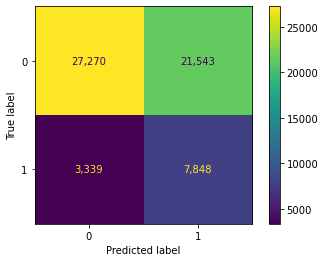

In [64]:
# Now use that function with the val set!

evaluate(best_model, X_train, X_val, y_train, y_val, roc_auc='proba')

## Discussion Time!

What does it mean to decide between model types? What do we think best represents this data? What else might I want to explore or understand before deciding that?

- 


## Resources

Check out Aurélien Geron's notebook of an [end-to-end ml project](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on his GitHub repo based around his book [_Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed)_](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)